# Vežbe 2  - OCR teksta

Do sada je rađeno optičko prepoznavanje brojeva i matematičkih izraza. Kada je reč o čitanju stvarnog teksta, deo problema predstavlja i određivanje granica između reči i redova u tekstu. Kao rešenje moguće je koristiti K-means algoritam i klasifikovati razmak između regiona na dve grupe:
* Razmak između slova u reči
* Razmak između reči

In [47]:
from __future__ import print_function
#import potrebnih biblioteka
import cv2
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

#Sklearn biblioteka sa implementiranim K-means algoritmom
from sklearn import datasets
from sklearn.cluster import KMeans

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

In [48]:
#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u OCR basic
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

Modifikovati funkciju za određivanje regija od interesa, tako da vraća i vrednosti rastojanja po x osi, između svih regiona.

In [49]:
def select_roi(image_orig, image_bin):
    '''
    Funkcija kao u vežbi 2, iscrtava pravougaonike na originalnoj slici, pronalazi sortiran niz regiona sa slike,
    i dodatno treba da sačuva rastojanja između susednih regiona.
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #Način određivanja kontura je promenjen na spoljašnje konture: cv2.RETR_EXTERNAL
    regions_array = []
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour)
        region = image_bin[y:y+h+1,x:x+w+1];
        regions_array.append([resize_region(region), (x,y,w,h)])
        cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)

    regions_array = sorted(regions_array, key=lambda item: item[1][0])

    sorted_regions = [region[0] for region in regions_array]
    sorted_rectangles = [region[1] for region in regions_array]
    region_distances = []
    # Izdvojiti sortirane parametre opisujućih pravougaonika
    # Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
    for index in range(0, len(sorted_rectangles)-1):
        current = sorted_rectangles[index]
        next_rect = sorted_rectangles[index+1]
        distance = next_rect[0] - (current[0]+current[2]) #X_next - (X_current + W_current)
        region_distances.append(distance)

    return image_orig, sorted_regions, region_distances


U odnosu na alfabet prikazan na slici, definisati i obučiti neuronsku mrežu.
<img src="images/alphabet.png"></img>

In [50]:
def create_ann():
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(26, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, epochs=500, batch_size=1, verbose = 0, shuffle=False) 
      
    return ann

Broj prepoznatih regiona: 26


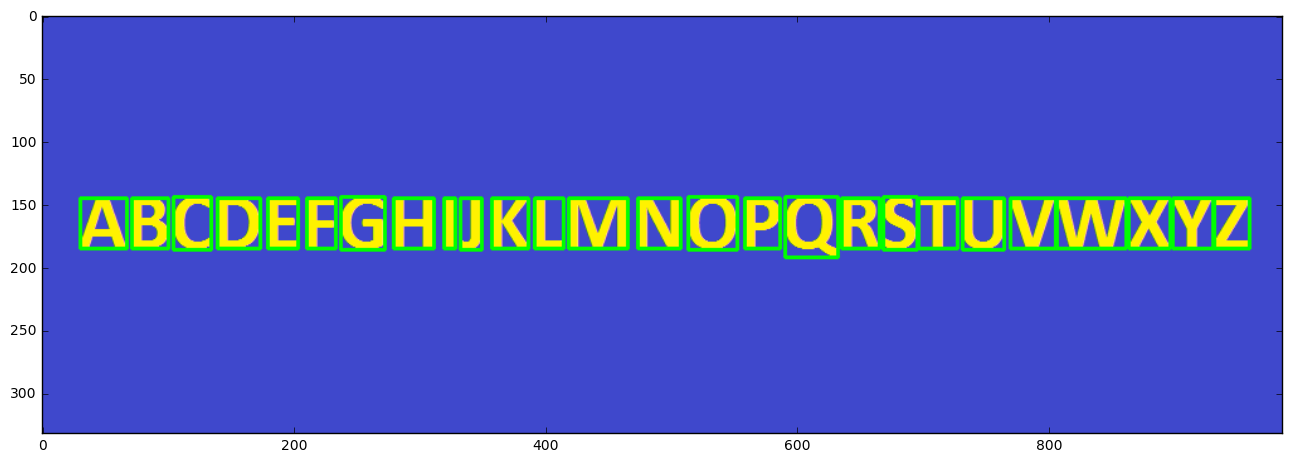

In [51]:
image_color = load_image('images/alphabet.png')
img = image_bin(image_gray(image_color))
selected_regions, letters, region_distances = select_roi(image_color.copy(), img)
display_image(selected_regions)
print ('Broj prepoznatih regiona:', len(letters))

In [52]:
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
inputs = prepare_for_ann(letters)
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

##### Iščitavanje pune rečenice.
Prvo se učitava slika, i određuju regioni od interesa kao i rastojanje među njima. Nakon toga, određuju se centri
dve grupe rastojanja K-means algoritmom.

Broj prepoznatih regiona: 22


KMeans(copy_x=True, init='k-means++', max_iter=2000, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=1e-05,
    verbose=0)

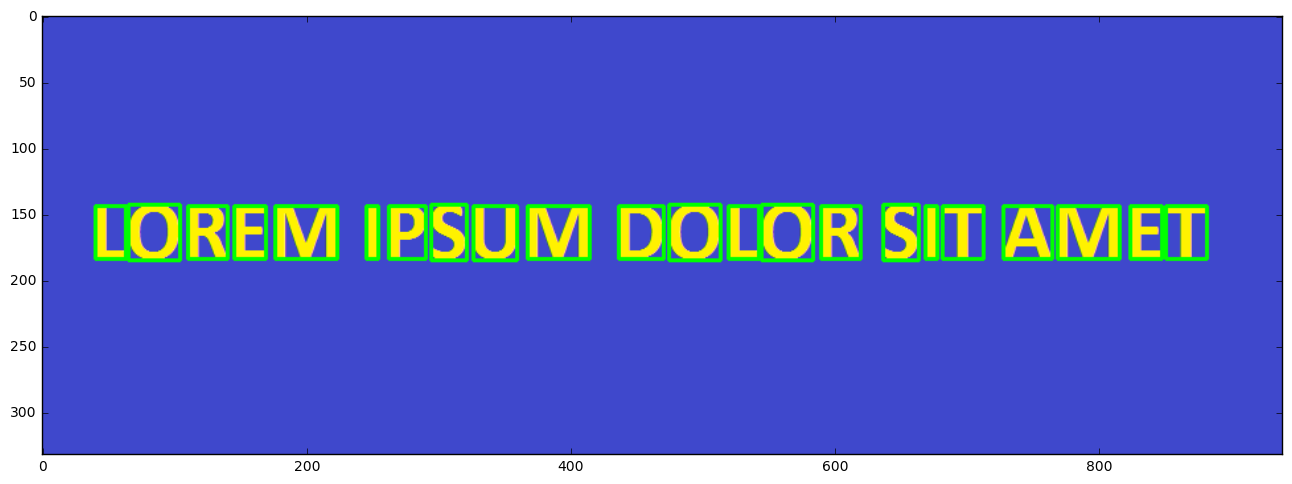

In [53]:
#Učitavanje slike i određivanje regiona od interesa
image_color = load_image('images/LoremIpsum.png')
img = image_bin(image_gray(image_color))
selected_regions, letters, distances = select_roi(image_color.copy(), img)
display_image(selected_regions)
print('Broj prepoznatih regiona:', len(letters))

#Podešavanje centara grupa K-means algoritmom
distances = np.array(distances).reshape(len(distances), 1)
#Neophodno je da u K-means algoritam bude prosleđena matrica u kojoj vrste određuju elemente

k_means = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means.fit(distances)

Potrebno je promeniti funkciju za prikaz rezultata da detektuje i razmake

In [54]:
def display_result(outputs, alphabet, k_means):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    # Odrediti indeks grupe koja odgovara rastojanju između reči, pomoću vrednosti iz k_means.cluster_centers_
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        # Iterativno dodavati prepoznate elemente kao u vežbi 2, alphabet[winner(output)]
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        if (k_means.labels_[idx] == w_space_group):
            result += ' '
        result += alphabet[winner(output)]
    return result

# Izvršavanje predikcije

In [55]:
inputs = prepare_for_ann(letters)
results = ann.predict(np.array(inputs, np.float32))
print(display_result(results, alphabet, k_means))

LOREM IPSUM DOLOR SIT AMET


# TODO dodatno
Proširiti algoritam mogućnošću da prepoznaje redove. Primer slike za prepoznavanje je
<i>images/Dodatno.png</i>